In [ ]:
!pip install clearml

In [2]:
# Импорт необходимых библиотек для реализации CycleGAN

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
from torch.optim.lr_scheduler import StepLR 
from clearml import Task, Logger

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=''
%env CLEARML_API_SECRET_KEY=''

In [8]:
# Инициализируем удаленную таску
task = Task.init(
        project_name="CycleGAN_Monet",
        task_name="CycleGAN_150_epoch",
        task_type="testing",
)
task:Task

logger = Logger.current_logger()

ClearML Task: created new task id=bfe1f27294c54cfeb6ce4bdfe703b7d0
2025-11-07 09:50:12,126 - clearml.Repository Detection - WARNING - Jupyter Notebook auto-logging failed, could not access: /kaggle/working/__notebook_source__.ipynb
2025-11-07 09:50:12,145 - clearml.Task - INFO - Storing jupyter notebook directly as code


2025-11-07 09:50:14.725997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762509014.923386      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762509014.977029      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ClearML results page: https://app.clear.ml/projects/dd2741cd0db04109aa77c8affeab4ecd/experiments/bfe1f27294c54cfeb6ce4bdfe703b7d0/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [9]:
# Фиксация seed для воспроизводимости результатов

def fix_seeds(seed: int):
    np.random.seed(seed)  # Для numpy операций
    random.seed(seed)  # Для встроенного random, который используется в DataLoader
    torch.manual_seed(seed)  # Для CPU операций PyTorch
    torch.cuda.manual_seed(seed)  # Для GPU операций 

fix_seeds(0)

In [10]:
# Создание Residual блок - ключевой компонент для глубоких сетей, который позволяет избежать проблемы затухающих градиентов через skip connection

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),  
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.conv_block(x)

In [11]:
# Создание генератора с архитектурой encoder-transformer-decoder

class Generator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, n_residual_blocks=11):
        super(Generator, self).__init__()
        
        # Encoder - начальный слой извлечения признаков
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, 7), 
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling - уменьшение пространственного разрешения с увеличением каналов
        in_channels = 64
        for _ in range(2):
            out_channels = in_channels * 2
            model += [
                nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
        
        # Transformer - обработка в пространстве признаков через residual блоки
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_channels)]
        
        # Upsampling - восстановление исходного разрешения
        for _ in range(2):
            out_channels = in_channels // 2
            model += [
                nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
        
        # Decoder - финальный слой для получения RGB изображения
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_channels, 7),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)


In [12]:
# Создание PatchGAN Discriminator - классифицирует не все изображение целиком, а отдельные патчи (небольшие области изображения).

class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        
        # Вспомогательная функция для создания блоков дискриминатора
        def discriminator_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))  # LeakyReLU для стабильности обучения
            return layers
        
        # Архитектура - серия сверточных слоев со stride=2 
        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, normalize=False),
            *discriminator_block(64, 128),   
            *discriminator_block(128, 256), 
            *discriminator_block(256, 512), 
            nn.ZeroPad2d((1, 0, 1, 0)),  # Асимметричный padding для корректной свертки
            nn.Conv2d(512, 1, 4, padding=1)  # Карта вероятностей на выходе  
        )
    
    def forward(self, img):
        return self.model(img)

In [13]:
# Создание Датасета

class MonetPhotoDataset(torch.utils.data.Dataset):
    def __init__(self, monet_dir, photo_dir, transform=None):
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.transform = transform
        
        # Загрузка списков файлов
        self.monet_files = [f for f in os.listdir(monet_dir) if f.endswith('.jpg')]
        all_photo_files = [f for f in os.listdir(photo_dir) if f.endswith('.jpg')]
        self.photo_files = random.sample(all_photo_files, k=1000) # Ограничиваем количество фото для ускорения обучения
        
    def __len__(self):
        # Определение длины бОльшим датасетом
        return max(len(self.monet_files), len(self.photo_files))
    
    def __getitem__(self, idx):
        # Используется random.choice вместо индексации по idx, чтобы обеспечить случайное сопоставление
        monet_file = random.choice(self.monet_files)
        photo_file = random.choice(self.photo_files)
        
        monet_path = os.path.join(self.monet_dir, monet_file)
        photo_path = os.path.join(self.photo_dir, photo_file)
        
        # Загрузка и конвертация в RGB
        monet_img = Image.open(monet_path).convert('RGB')
        photo_img = Image.open(photo_path).convert('RGB')
        
        # Подготовка изображений
        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)
            
        return photo_img, monet_img

In [14]:
# Создание Image Pool - для стабилизации обучения GAN

class ImagePool:
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        # Возвращение изображения из истории вместо только текущих
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:
                # Заполнение pool до максимального размера
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                # Pool заполнен: с вероятностью 50% возвращается старое изображение
                p = random.uniform(0, 1)
                if p > 0.5:
                    # Замена случайного изображения в pool и возвращение старого
                    random_id = random.randint(0, self.pool_size - 1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    # Возвращение текущего изображения
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)
        return return_images


In [15]:
# Создание основного класса CycleGAN, объединяющего все компоненты

class CycleGAN:
    def __init__(self, device='cuda'):
        self.device = device
        
        # Инициализация двух генераторов и двух дискриминаторов
        self.G_photo_to_monet = Generator().to(device)
        self.G_monet_to_photo = Generator().to(device)
        self.D_photo = Discriminator().to(device)
        self.D_monet = Discriminator().to(device)
        
        # Оптимизаторы Adam для генераторов и дискриминаторов
        self.optimizer_G = optim.Adam(
            list(self.G_photo_to_monet.parameters()) + list(self.G_monet_to_photo.parameters()),
            lr=0.0002, betas=(0.5, 0.999)
        )
        self.optimizer_D_photo = optim.Adam(self.D_photo.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizer_D_monet = optim.Adam(self.D_monet.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # Schedulers для постепенного снижения learning rate для улучшения сходимости
        self.scheduler_G = StepLR(self.optimizer_G, step_size=50, gamma=0.5)
        self.scheduler_D_photo = StepLR(self.optimizer_D_photo, step_size=50, gamma=0.5)  
        self.scheduler_D_monet = StepLR(self.optimizer_D_monet, step_size=50, gamma=0.5)

        # Функции потерь для разных компонентов
        self.criterion_gan = nn.MSELoss()  # Для adversarial loss (насколько хорошо генератор обманывает дискриминатор)
        self.criterion_cycle = nn.L1Loss()  # Для cycle consistency loss (гарантия того, что преобразование обратимо)
        self.criterion_identity = nn.L1Loss()  # Для identity loss (сохранение цветовой гаммы и предотвращение излишних изменений)
        
        # Веса для компонентов функции потерь
        self.lambda_cycle = 10.0  # Cycle consistency - заставляет модель сохранять содержание изображения при преобразовании
        self.lambda_identity = 0.5  # Identity loss - помогает сохранить цветовую гамму оригинала
        
        # Image pools для стабилизации обучения дискриминаторов - используют историю сгенерированных изображений вместо только текущих
        self.fake_photo_buffer = ImagePool(50) # Хранит 50 последних сгенерированных изображений
        self.fake_monet_buffer = ImagePool(50)
    
    def set_input(self, real_photo, real_monet):
        # Перемещение батчей данных на устройство (CPU/GPU)
        self.real_photo = real_photo.to(self.device)
        self.real_monet = real_monet.to(self.device)
    
    def forward(self):
        # Forward pass через оба генератора
        self.fake_monet = self.G_photo_to_monet(self.real_photo) # photo - fake_monet - reconstructed_photo
        self.rec_photo = self.G_monet_to_photo(self.fake_monet)
        self.fake_photo = self.G_monet_to_photo(self.real_monet) # monet - fake_photo - reconstructed_monet
        self.rec_monet = self.G_photo_to_monet(self.fake_photo)
    
    def backward_D_basic(self, netD, real, fake):
        # Базовая функция для обучения дискриминатора (отличие реальных изображений от сгенерированных)
        pred_real = netD(real)
        loss_D_real = self.criterion_gan(pred_real, torch.ones_like(pred_real))
        pred_fake = netD(fake.detach()) # Обязательное применение detach - останавливаем градиент через генератор
        loss_D_fake = self.criterion_gan(pred_fake, torch.zeros_like(pred_fake))
        
        # Общий loss дискриминатора (среднее между real и fake)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D
    
    def backward_D_photo(self):
        # Обучение дискриминатора для фото, используем image pool для стабилизации
        fake_photo = self.fake_photo_buffer.query(self.fake_photo)
        self.loss_D_photo = self.backward_D_basic(self.D_photo, self.real_photo, fake_photo)
    
    def backward_D_monet(self):
        # Обучение дискриминатора для картин Моне
        fake_monet = self.fake_monet_buffer.query(self.fake_monet)
        self.loss_D_monet = self.backward_D_basic(self.D_monet, self.real_monet, fake_monet)
        
    def backward_G(self):
        # Обучение генераторов
        
        # Identity Loss - сохранение цветовой схемы исходных изображений
        idt_photo = self.G_monet_to_photo(self.real_photo)
        loss_idt_photo = self.criterion_identity(idt_photo, self.real_photo) * self.lambda_cycle * self.lambda_identity
        
        idt_monet = self.G_photo_to_monet(self.real_monet)
        loss_idt_monet = self.criterion_identity(idt_monet, self.real_monet) * self.lambda_cycle * self.lambda_identity
        
        # Adversarial Loss - обман дискриминаторов
        pred_fake_photo = self.D_photo(self.fake_photo)
        loss_G_monet_to_photo = self.criterion_gan(pred_fake_photo, torch.ones_like(pred_fake_photo))
        pred_fake_monet = self.D_monet(self.fake_monet)
        loss_G_photo_to_monet = self.criterion_gan(pred_fake_monet, torch.ones_like(pred_fake_monet))
        
        # Cycle Consistency Loss - гарантия того, что преобразование обратимо
        loss_cycle_photo = self.criterion_cycle(self.rec_photo, self.real_photo) * self.lambda_cycle
        loss_cycle_monet = self.criterion_cycle(self.rec_monet, self.real_monet) * self.lambda_cycle
        
        # Суммирование всех компонентов loss для генераторов
        self.loss_G = loss_G_photo_to_monet + loss_G_monet_to_photo + loss_cycle_photo + loss_cycle_monet + loss_idt_photo + loss_idt_monet
        self.loss_G.backward()
    
    def optimize_parameters(self):
        # Полный цикл обучения для одного батча
        
        # Forward pass - генерируем все необходимые изображения
        self.forward()

        # Обновление генераторов
        self.optimizer_G.zero_grad()  # Обнуляем градиенты
        self.backward_G()  # Вычисляем градиенты
        self.optimizer_G.step()  # Применяем обновление весов

        # Обновление дискриминатора для фото
        self.optimizer_D_photo.zero_grad()
        self.backward_D_photo()
        self.optimizer_D_photo.step()
        
        # Обновление дискриминатора для картин Моне
        self.optimizer_D_monet.zero_grad()
        self.backward_D_monet()
        self.optimizer_D_monet.step()


In [16]:
# Основной цикл обучения CycleGAN

def train_cyclegan(model, dataloader, num_epochs=200, save_interval=50):
    # Перевод всех моделей в режим обучения
    model.G_photo_to_monet.train()
    model.G_monet_to_photo.train()
    model.D_photo.train()
    model.D_monet.train()
    
    for epoch in range(num_epochs):
        # Начальные значения для вычисления средних значений loss
        epoch_loss_G = 0
        epoch_loss_D_photo = 0
        epoch_loss_D_monet = 0
        
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for i, (photos, monets) in enumerate(progress_bar):
            # Установка входных данных и выполнение одного шага обучения
            model.set_input(photos, monets)
            model.optimize_parameters()
            
            # Накапливание losses для статистики
            epoch_loss_G += model.loss_G.item()
            epoch_loss_D_photo += model.loss_D_photo.item()
            epoch_loss_D_monet += model.loss_D_monet.item()
            
            # # Отображение текущих losses в progress bar
            # progress_bar.set_postfix({
            #     'Loss_G': f'{model.loss_G.item():.4f}',
            #     'Loss_D_Photo': f'{model.loss_D_photo.item():.4f}',
            #     'Loss_D_Monet': f'{model.loss_D_monet.item():.4f}'
            # })
        
        # Вычисление средних losses за эпоху
        avg_loss_G = epoch_loss_G / len(dataloader)
        avg_loss_D_photo = epoch_loss_D_photo / len(dataloader)
        avg_loss_D_monet = epoch_loss_D_monet / len(dataloader)
        
        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Loss_G: {avg_loss_G:.4f}, '
              f'Loss_D_Photo: {avg_loss_D_photo:.4f}, '
              f'Loss_D_Monet: {avg_loss_D_monet:.4f}') 
        
        # Логгирование метрик в ClearML
        logger.report_scalar(title='Loss Generator', series='Loss_G', value=avg_loss_G, iteration=epoch)
        logger.report_scalar(title='Loss Discriminator Photo', series='Loss_D_Photo', value=avg_loss_D_photo, iteration=epoch)
        logger.report_scalar(title='Loss Discriminator Monet', series='Loss_D_Monet', value=avg_loss_D_monet, iteration=epoch)
        
        # Периодическое сохранение checkpoint для возможности продолжения обучения
        if (epoch + 1) % save_interval == 0:
            checkpoint_path = f'cyclegan_checkpoint_epoch_{epoch+1}.pt'
            
            torch.save({
                'epoch': epoch,
                'G_photo_to_monet': model.G_photo_to_monet.state_dict(),
                'G_monet_to_photo': model.G_monet_to_photo.state_dict(),
                'D_photo': model.D_photo.state_dict(),
                'D_monet': model.D_monet.state_dict(),
                'optimizer_G': model.optimizer_G.state_dict(),
                'optimizer_D_photo': model.optimizer_D_photo.state_dict(),
                'optimizer_D_monet': model.optimizer_D_monet.state_dict(),
            }, checkpoint_path)
            print(f'Модель сохранена на эпохе {epoch+1}')
            
            # Загружаем в ClearML с метаданными
            task.upload_artifact(
                name=f'checkpoint_epoch_{epoch+1}',
                artifact_object=checkpoint_path,
                metadata={
                    'epoch': epoch+1,
                    'avg_loss_G': float(avg_loss_G),
                    'avg_loss_D_photo': float(avg_loss_D_photo),
                    'avg_loss_D_monet': float(avg_loss_D_monet),
                    'learning_rate': model.optimizer_G.param_groups[0]['lr']
                }
            )
            
        # Обновление learning rate согласно scheduler
        model.scheduler_G.step()
        model.scheduler_D_photo.step()
        model.scheduler_D_monet.step()


In [17]:
# Вспомогательная функция для денормализации и конвертации тензора в изображение
def denorm_tensor_to_pil(img_tensor):
    t = img_tensor.clone().cpu()
    t = (t + 1.0) / 2.0  # Денормализация из [-1, 1] в [0, 1]
    t = t.clamp(0,1)  # Обрезка значения для безопасности
    t = (t * 255).byte()  # Конвертация в [0, 255]
    t = t.permute(1,2,0).numpy()  # CHW в HWC  
    return Image.fromarray(t) #Создание изображения из numpy массива

# Функция для генерации всех изображений в стиле Моне и сохранения в zip (обработка батчами для эффективности на GPU)
def generate_monet_images(model, photo_dir, zip_name='monet_generated.zip', device='cpu', batch_size=8):
    # Модели в режиме train (т.к. InstanceNorm)
    model.G_photo_to_monet.train()
    model.G_monet_to_photo.train()
    model.D_photo.train()
    model.D_monet.train()
    
    # Подготовка данных для генерации
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3), 
    ])
    
    photo_files = [f for f in os.listdir(photo_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    total_files = len(photo_files)
    generated_count = 0
    
    print(f"Начинаю генерацию {total_files} изображений батчами по {batch_size}...")
  
    # Создание zip файла для submission
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED, compresslevel=1) as zipf:
        with torch.no_grad():  # Отключение вычисления градиентов
            for batch_start in tqdm(range(0, total_files, batch_size), desc='Обработка батчей'):
                batch_end = min(batch_start + batch_size, total_files)
                batch_files = photo_files[batch_start:batch_end]
                
                # Формирование батча изображений
                batch_images = []
                valid_files = []
                
                for photo_file in batch_files:
                    try:
                        photo_path = os.path.join(photo_dir, photo_file)
                        img = Image.open(photo_path).convert('RGB')
                        img_tensor = transform(img)
                        batch_images.append(img_tensor)
                        valid_files.append(photo_file)
                    except Exception as e:
                        print(f'Ошибка загрузки {photo_file}: {e}')
                        continue
                
                if not batch_images:
                    continue
                
                # Объединение списка тензоров в один батч
                batch_tensor = torch.stack(batch_images).to(device)
                
                # Генерация изображений в стиле Моне
                if hasattr(model, 'G_photo_to_monet'):
                    generated_batch = model.G_photo_to_monet(batch_tensor)
                else:
                    generated_batch = model(batch_tensor)
                
                # Сохранение каждого изображения из батча
                for i, photo_file in enumerate(valid_files):
                    try:
                        out_tensor = generated_batch[i]
                        # Денормализация из [-1, 1] в [0, 1]
                        out_tensor = (out_tensor + 1.0) / 2.0
                        out_tensor = out_tensor.clamp(0, 1)
                        
                        # Конвертация в PIL изображение
                        out_tensor = (out_tensor * 255).byte()
                        out_tensor = out_tensor.permute(1, 2, 0).cpu().numpy()
                        pil_img = Image.fromarray(out_tensor)
                        
                        # Сохранение в памяти как JPEG
                        img_bytes = io.BytesIO()
                        pil_img.save(img_bytes, format='JPEG', quality=85, optimize=True)
                        img_bytes.seek(0)
                        
                        # Добавление в zip архив с правильным именем для submission
                        out_name = os.path.splitext(photo_file)[0] + '_monet.jpg'
                        zipf.writestr(out_name, img_bytes.getvalue())
                        generated_count += 1
                        
                    except Exception as e:
                        print(f'Ошибка обработки {photo_file}: {e}')
                        continue
                
                # Очистка памяти для предотвращения OOM на GPU
                del batch_tensor, generated_batch, batch_images
                torch.cuda.empty_cache() if device == 'cuda' else None
    
    return generated_count, zip_name


In [18]:
# Настройка устройства для обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используется устройство: {device}')

# Пути к данным 
monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'  
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'  

# Проверка наличия данных
if not os.path.exists(monet_dir):
    print(f'ОШИБКА: Каталог {monet_dir} не найден!')
if not os.path.exists(photo_dir):
    print(f'ОШИБКА: Каталог {photo_dir} не найден!')

# Подготовка данных
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

if os.path.exists(monet_dir) and os.path.exists(photo_dir):
    # Создание датасета и dataloader
    dataset = MonetPhotoDataset(monet_dir, photo_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=6, shuffle=True, num_workers=4, pin_memory=True)
    print(f'Датасет создан: {len(dataset)} пар изображений')
    
    # Инициализация модели CycleGAN
    model = CycleGAN(device=device)
    print('Модель CycleGAN создана')
    
    # Подсчет параметров для понимания размера модели
    total_params = sum(p.numel() for p in model.G_photo_to_monet.parameters())
    print(f'Количество параметров генератора: {total_params:,}')
else:
    print('Создание датасета пропущено из-за отсутствующих каталогов')


Используется устройство: cuda
Датасет создан: 1000 пар изображений
Модель CycleGAN создана
Количество параметров генератора: 13,738,499


In [ ]:
# Гиперпараметры обучения
NUM_EPOCHS = 201  
SAVE_INTERVAL = 50  

# Запуск процесса обучения
train_cyclegan(model, dataloader, num_epochs=NUM_EPOCHS, save_interval=SAVE_INTERVAL)


Epoch 1/200: 100%|██████████| 167/167 [04:36<00:00,  1.65s/it]


Epoch 1/200 - Loss_G: 9.3317, Loss_D_Photo: 0.2540, Loss_D_Monet: 0.2535


Epoch 2/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 2/200 - Loss_G: 8.2335, Loss_D_Photo: 0.1860, Loss_D_Monet: 0.1717


Epoch 3/200: 100%|██████████| 167/167 [04:34<00:00,  1.65s/it]


Epoch 3/200 - Loss_G: 7.6576, Loss_D_Photo: 0.1616, Loss_D_Monet: 0.2121


Epoch 4/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 4/200 - Loss_G: 7.3305, Loss_D_Photo: 0.1624, Loss_D_Monet: 0.1604


Epoch 5/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 5/200 - Loss_G: 7.0345, Loss_D_Photo: 0.1648, Loss_D_Monet: 0.1559


Epoch 6/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 6/200 - Loss_G: 6.7842, Loss_D_Photo: 0.1508, Loss_D_Monet: 0.1445


Epoch 7/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 7/200 - Loss_G: 6.6922, Loss_D_Photo: 0.1587, Loss_D_Monet: 0.1258


Epoch 8/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 8/200 - Loss_G: 6.4532, Loss_D_Photo: 0.1558, Loss_D_Monet: 0.1414


Epoch 9/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 9/200 - Loss_G: 6.2693, Loss_D_Photo: 0.1510, Loss_D_Monet: 0.1222


Epoch 10/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 10/200 - Loss_G: 6.1012, Loss_D_Photo: 0.1485, Loss_D_Monet: 0.1175


Epoch 11/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 11/200 - Loss_G: 5.9824, Loss_D_Photo: 0.1405, Loss_D_Monet: 0.1087


Epoch 12/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 12/200 - Loss_G: 5.9145, Loss_D_Photo: 0.1455, Loss_D_Monet: 0.1885


Epoch 13/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 13/200 - Loss_G: 5.4535, Loss_D_Photo: 0.1486, Loss_D_Monet: 0.1713


Epoch 14/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 14/200 - Loss_G: 5.4882, Loss_D_Photo: 0.1346, Loss_D_Monet: 0.1112


Epoch 15/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 15/200 - Loss_G: 5.5505, Loss_D_Photo: 0.1343, Loss_D_Monet: 0.0873


Epoch 16/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 16/200 - Loss_G: 5.5762, Loss_D_Photo: 0.1377, Loss_D_Monet: 0.0636


Epoch 17/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 17/200 - Loss_G: 5.5197, Loss_D_Photo: 0.1294, Loss_D_Monet: 0.0505


Epoch 18/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 18/200 - Loss_G: 5.4307, Loss_D_Photo: 0.1320, Loss_D_Monet: 0.0667


Epoch 19/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 19/200 - Loss_G: 5.2265, Loss_D_Photo: 0.1233, Loss_D_Monet: 0.0791


Epoch 20/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 20/200 - Loss_G: 5.0029, Loss_D_Photo: 0.1279, Loss_D_Monet: 0.4317


Epoch 21/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 21/200 - Loss_G: 4.6618, Loss_D_Photo: 0.1114, Loss_D_Monet: 0.2346


Epoch 22/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 22/200 - Loss_G: 4.6230, Loss_D_Photo: 0.1024, Loss_D_Monet: 0.2247


Epoch 23/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 23/200 - Loss_G: 4.6027, Loss_D_Photo: 0.0985, Loss_D_Monet: 0.2202


Epoch 24/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 24/200 - Loss_G: 4.6941, Loss_D_Photo: 0.0860, Loss_D_Monet: 0.1812


Epoch 25/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 25/200 - Loss_G: 4.7222, Loss_D_Photo: 0.0875, Loss_D_Monet: 0.1327


Epoch 26/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 26/200 - Loss_G: 5.2602, Loss_D_Photo: 0.4754, Loss_D_Monet: 0.1025


Epoch 27/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 27/200 - Loss_G: 4.3703, Loss_D_Photo: 0.2354, Loss_D_Monet: 0.1376


Epoch 28/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 28/200 - Loss_G: 4.2725, Loss_D_Photo: 0.2331, Loss_D_Monet: 0.0875


Epoch 29/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 29/200 - Loss_G: 4.3962, Loss_D_Photo: 0.2312, Loss_D_Monet: 0.0735


Epoch 30/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 30/200 - Loss_G: 4.2952, Loss_D_Photo: 0.2258, Loss_D_Monet: 0.0625


Epoch 31/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 31/200 - Loss_G: 4.3279, Loss_D_Photo: 0.2238, Loss_D_Monet: 0.0620


Epoch 32/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 32/200 - Loss_G: 4.2560, Loss_D_Photo: 0.2230, Loss_D_Monet: 0.0864


Epoch 33/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 33/200 - Loss_G: 4.2091, Loss_D_Photo: 0.2190, Loss_D_Monet: 0.0936


Epoch 34/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 34/200 - Loss_G: 4.3916, Loss_D_Photo: 0.2147, Loss_D_Monet: 0.3200


Epoch 35/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 35/200 - Loss_G: 3.7762, Loss_D_Photo: 0.2106, Loss_D_Monet: 0.2372


Epoch 36/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 36/200 - Loss_G: 3.6929, Loss_D_Photo: 0.2056, Loss_D_Monet: 0.2360


Epoch 37/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 37/200 - Loss_G: 3.7049, Loss_D_Photo: 0.1866, Loss_D_Monet: 0.2271


Epoch 38/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 38/200 - Loss_G: 3.7456, Loss_D_Photo: 0.2062, Loss_D_Monet: 0.2119


Epoch 39/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 39/200 - Loss_G: 3.7605, Loss_D_Photo: 0.1611, Loss_D_Monet: 0.1907


Epoch 40/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 40/200 - Loss_G: 3.8912, Loss_D_Photo: 0.1503, Loss_D_Monet: 0.1296


Epoch 41/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 41/200 - Loss_G: 4.1131, Loss_D_Photo: 0.1401, Loss_D_Monet: 0.1023


Epoch 42/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 42/200 - Loss_G: 4.1386, Loss_D_Photo: 0.1324, Loss_D_Monet: 0.3234


Epoch 43/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 43/200 - Loss_G: 3.7275, Loss_D_Photo: 0.1435, Loss_D_Monet: 0.2045


Epoch 44/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 44/200 - Loss_G: 3.9934, Loss_D_Photo: 0.2680, Loss_D_Monet: 0.1303


Epoch 45/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 45/200 - Loss_G: 3.8536, Loss_D_Photo: 0.2282, Loss_D_Monet: 0.0870


Epoch 46/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 46/200 - Loss_G: 3.8186, Loss_D_Photo: 0.2173, Loss_D_Monet: 0.0912


Epoch 47/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 47/200 - Loss_G: 3.7344, Loss_D_Photo: 0.1971, Loss_D_Monet: 0.0840


Epoch 48/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 48/200 - Loss_G: 3.8341, Loss_D_Photo: 0.1759, Loss_D_Monet: 0.0891


Epoch 49/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 49/200 - Loss_G: 3.9187, Loss_D_Photo: 0.1493, Loss_D_Monet: 0.0831


Epoch 50/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 50/200 - Loss_G: 4.1207, Loss_D_Photo: 0.1449, Loss_D_Monet: 0.0773
Модель сохранена на эпохе 50


Epoch 51/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 51/200 - Loss_G: 3.5043, Loss_D_Photo: 0.1493, Loss_D_Monet: 0.0674


Epoch 52/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 52/200 - Loss_G: 3.4704, Loss_D_Photo: 0.1522, Loss_D_Monet: 0.0783


Epoch 53/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 53/200 - Loss_G: 3.5137, Loss_D_Photo: 0.1505, Loss_D_Monet: 0.0757


Epoch 54/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 54/200 - Loss_G: 3.4361, Loss_D_Photo: 0.1560, Loss_D_Monet: 0.0820


Epoch 55/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 55/200 - Loss_G: 3.4591, Loss_D_Photo: 0.1511, Loss_D_Monet: 0.0793


Epoch 56/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 56/200 - Loss_G: 3.5068, Loss_D_Photo: 0.1494, Loss_D_Monet: 0.0743


Epoch 57/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 57/200 - Loss_G: 3.4844, Loss_D_Photo: 0.1467, Loss_D_Monet: 0.0758


Epoch 58/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 58/200 - Loss_G: 3.5007, Loss_D_Photo: 0.1499, Loss_D_Monet: 0.0751


Epoch 59/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 59/200 - Loss_G: 3.5554, Loss_D_Photo: 0.1494, Loss_D_Monet: 0.0738


Epoch 60/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 60/200 - Loss_G: 3.6558, Loss_D_Photo: 0.1482, Loss_D_Monet: 0.2118


Epoch 61/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 61/200 - Loss_G: 3.1673, Loss_D_Photo: 0.1429, Loss_D_Monet: 0.1935


Epoch 62/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 62/200 - Loss_G: 3.1717, Loss_D_Photo: 0.1506, Loss_D_Monet: 0.1388


Epoch 63/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 63/200 - Loss_G: 3.3351, Loss_D_Photo: 0.1417, Loss_D_Monet: 0.0936


Epoch 64/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 64/200 - Loss_G: 3.3737, Loss_D_Photo: 0.1454, Loss_D_Monet: 0.0798


Epoch 65/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 65/200 - Loss_G: 3.4265, Loss_D_Photo: 0.1392, Loss_D_Monet: 0.0799


Epoch 66/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 66/200 - Loss_G: 3.4675, Loss_D_Photo: 0.1415, Loss_D_Monet: 0.0796


Epoch 67/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 67/200 - Loss_G: 3.5031, Loss_D_Photo: 0.1397, Loss_D_Monet: 0.0783


Epoch 68/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 68/200 - Loss_G: 3.4682, Loss_D_Photo: 0.1398, Loss_D_Monet: 0.0785


Epoch 69/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 69/200 - Loss_G: 3.4561, Loss_D_Photo: 0.1437, Loss_D_Monet: 0.0799


Epoch 70/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 70/200 - Loss_G: 3.4688, Loss_D_Photo: 0.1378, Loss_D_Monet: 0.0793


Epoch 71/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 71/200 - Loss_G: 3.4349, Loss_D_Photo: 0.1383, Loss_D_Monet: 0.0762


Epoch 72/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 72/200 - Loss_G: 3.4706, Loss_D_Photo: 0.1380, Loss_D_Monet: 0.0787


Epoch 73/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 73/200 - Loss_G: 3.4369, Loss_D_Photo: 0.1395, Loss_D_Monet: 0.0793


Epoch 74/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 74/200 - Loss_G: 3.4604, Loss_D_Photo: 0.1404, Loss_D_Monet: 0.0783


Epoch 75/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 75/200 - Loss_G: 3.4232, Loss_D_Photo: 0.1393, Loss_D_Monet: 0.0798


Epoch 76/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 76/200 - Loss_G: 3.4745, Loss_D_Photo: 0.1363, Loss_D_Monet: 0.0772


Epoch 77/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 77/200 - Loss_G: 3.4942, Loss_D_Photo: 0.1329, Loss_D_Monet: 0.0754


Epoch 78/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 78/200 - Loss_G: 3.4773, Loss_D_Photo: 0.1415, Loss_D_Monet: 0.0820


Epoch 79/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 79/200 - Loss_G: 3.5319, Loss_D_Photo: 0.1282, Loss_D_Monet: 0.0727


Epoch 80/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 80/200 - Loss_G: 3.4886, Loss_D_Photo: 0.1383, Loss_D_Monet: 0.0719


Epoch 81/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 81/200 - Loss_G: 3.4862, Loss_D_Photo: 0.1352, Loss_D_Monet: 0.0724


Epoch 82/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 82/200 - Loss_G: 3.5279, Loss_D_Photo: 0.1298, Loss_D_Monet: 0.0717


Epoch 83/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 83/200 - Loss_G: 3.4981, Loss_D_Photo: 0.1388, Loss_D_Monet: 0.0697


Epoch 84/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 84/200 - Loss_G: 3.5784, Loss_D_Photo: 0.1305, Loss_D_Monet: 0.0699


Epoch 85/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 85/200 - Loss_G: 5.6845, Loss_D_Photo: 0.7629, Loss_D_Monet: 0.8568


Epoch 86/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 86/200 - Loss_G: 3.3395, Loss_D_Photo: 0.1683, Loss_D_Monet: 0.1664


Epoch 87/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 87/200 - Loss_G: 3.1147, Loss_D_Photo: 0.1622, Loss_D_Monet: 0.1640


Epoch 88/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 88/200 - Loss_G: 3.0191, Loss_D_Photo: 0.1606, Loss_D_Monet: 0.1563


Epoch 89/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 89/200 - Loss_G: 2.9907, Loss_D_Photo: 0.1536, Loss_D_Monet: 0.1430


Epoch 90/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 90/200 - Loss_G: 3.0281, Loss_D_Photo: 0.1501, Loss_D_Monet: 0.1309


Epoch 91/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 91/200 - Loss_G: 3.0648, Loss_D_Photo: 0.1455, Loss_D_Monet: 0.1164


Epoch 92/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 92/200 - Loss_G: 3.1311, Loss_D_Photo: 0.1446, Loss_D_Monet: 0.1018


Epoch 93/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 93/200 - Loss_G: 3.1832, Loss_D_Photo: 0.1434, Loss_D_Monet: 0.0935


Epoch 94/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 94/200 - Loss_G: 3.3839, Loss_D_Photo: 0.1352, Loss_D_Monet: 0.0747


Epoch 95/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 95/200 - Loss_G: 3.2360, Loss_D_Photo: 0.1453, Loss_D_Monet: 0.0830


Epoch 96/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 96/200 - Loss_G: 3.2443, Loss_D_Photo: 0.1473, Loss_D_Monet: 0.0838


Epoch 97/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 97/200 - Loss_G: 3.2483, Loss_D_Photo: 0.1467, Loss_D_Monet: 0.0808


Epoch 98/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 98/200 - Loss_G: 3.3052, Loss_D_Photo: 0.1440, Loss_D_Monet: 0.0816


Epoch 99/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 99/200 - Loss_G: 3.3032, Loss_D_Photo: 0.1444, Loss_D_Monet: 0.0822


Epoch 100/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 100/200 - Loss_G: 3.3112, Loss_D_Photo: 0.1545, Loss_D_Monet: 0.0804
Модель сохранена на эпохе 100


Epoch 101/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 101/200 - Loss_G: 3.0588, Loss_D_Photo: 0.1637, Loss_D_Monet: 0.0813


Epoch 102/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 102/200 - Loss_G: 3.0772, Loss_D_Photo: 0.1714, Loss_D_Monet: 0.0870


Epoch 103/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 103/200 - Loss_G: 3.0795, Loss_D_Photo: 0.1697, Loss_D_Monet: 0.0862


Epoch 104/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 104/200 - Loss_G: 3.0658, Loss_D_Photo: 0.1721, Loss_D_Monet: 0.0878


Epoch 105/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 105/200 - Loss_G: 3.0998, Loss_D_Photo: 0.1674, Loss_D_Monet: 0.0839


Epoch 106/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 106/200 - Loss_G: 3.1238, Loss_D_Photo: 0.1697, Loss_D_Monet: 0.0799


Epoch 107/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 107/200 - Loss_G: 3.1329, Loss_D_Photo: 0.1631, Loss_D_Monet: 0.0793


Epoch 108/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 108/200 - Loss_G: 3.1431, Loss_D_Photo: 0.1668, Loss_D_Monet: 0.0798


Epoch 109/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 109/200 - Loss_G: 3.1744, Loss_D_Photo: 0.1650, Loss_D_Monet: 0.0760


Epoch 110/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 110/200 - Loss_G: 3.2206, Loss_D_Photo: 0.1628, Loss_D_Monet: 0.0747


Epoch 111/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 111/200 - Loss_G: 3.2154, Loss_D_Photo: 0.1626, Loss_D_Monet: 0.0739


Epoch 112/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 112/200 - Loss_G: 3.2123, Loss_D_Photo: 0.1587, Loss_D_Monet: 0.0749


Epoch 113/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 113/200 - Loss_G: 3.2258, Loss_D_Photo: 0.1629, Loss_D_Monet: 0.0705


Epoch 114/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 114/200 - Loss_G: 3.2520, Loss_D_Photo: 0.1599, Loss_D_Monet: 0.0716


Epoch 115/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 115/200 - Loss_G: 3.2629, Loss_D_Photo: 0.1611, Loss_D_Monet: 0.0696


Epoch 116/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 116/200 - Loss_G: 3.3389, Loss_D_Photo: 0.1592, Loss_D_Monet: 0.0661


Epoch 117/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 117/200 - Loss_G: 3.2917, Loss_D_Photo: 0.1602, Loss_D_Monet: 0.0661


Epoch 118/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 118/200 - Loss_G: 3.2792, Loss_D_Photo: 0.1619, Loss_D_Monet: 0.0656


Epoch 119/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 119/200 - Loss_G: 3.2800, Loss_D_Photo: 0.1547, Loss_D_Monet: 0.0658


Epoch 120/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 120/200 - Loss_G: 3.3085, Loss_D_Photo: 0.1572, Loss_D_Monet: 0.0629


Epoch 121/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 121/200 - Loss_G: 3.3062, Loss_D_Photo: 0.1587, Loss_D_Monet: 0.0644


Epoch 122/200: 100%|██████████| 167/167 [04:34<00:00,  1.65s/it]


Epoch 122/200 - Loss_G: 3.3654, Loss_D_Photo: 0.1644, Loss_D_Monet: 0.0619


Epoch 123/200: 100%|██████████| 167/167 [04:34<00:00,  1.64s/it]


Epoch 123/200 - Loss_G: 3.3136, Loss_D_Photo: 0.1579, Loss_D_Monet: 0.0644


Epoch 124/200:  23%|██▎       | 38/167 [01:02<03:32,  1.64s/it]

In [31]:
# ID задачи, где хранится артефакт
task_id = 'bae9d2d4c61349b7b8ce92ae8000ae7b'

# Создаём пустой объект CycleGAN (такой же, как при обучении)
model = CycleGAN(device=device)

# Загружаем задачу
task = Task.get_task(task_id=task_id)

# Смотрим, какие артефакты есть у задачи
print('Доступные артефакты:', list(task.artifacts.keys()))

# Берём нужный артефакт (например, checkpoint)
artifact = task.artifacts['checkpoint_epoch_150']  # подставьте правильное имя

# Скачиваем файл локально
local_path = artifact.get_local_copy()
print('Веса скачаны в:', local_path)

# Загружаем веса в модель
checkpoint = torch.load(local_path, map_location=device)
model.G_photo_to_monet.load_state_dict(checkpoint['G_photo_to_monet'])
model.G_monet_to_photo.load_state_dict(checkpoint['G_monet_to_photo'])
model.D_photo.load_state_dict(checkpoint['D_photo'])
model.D_monet.load_state_dict(checkpoint['D_monet'])

print('Веса успешно восстановлены')

Доступные артефакты: ['checkpoint_epoch_100', 'checkpoint_epoch_150', 'checkpoint_epoch_50']
2025-11-07 10:08:04,037 - clearml.storage - INFO - Downloading: 377.90MB from https://files.clear.ml/CycleGAN_Monet/CycleGAN_200_epoch.bae9d2d4c61349b7b8ce92ae8000ae7b/artifacts/checkpoint_epoch_150/cyclegan_checkpoint_epoch_150.pt


██████████████████████████████ 100% | 377.90/377.9 MB [00:05<00:00, 64.83MB/s]: /usr/local/lib/python3.11/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

██████████████████████████████ 100% | 377.90/377.9 MB [00:05<00:00, 64.22MB/s]: 

2025-11-07 10:08:09,929 - clearml.storage - INFO - Downloaded 377.90 MB successfully from https://files.clear.ml/CycleGAN_Monet/CycleGAN_200_epoch.bae9d2d4c61349b7b8ce92ae8000ae7b/artifacts/checkpoint_epoch_150/cyclegan_checkpoint_epoch_150.pt , saved to /root/.clearml/cache/storage_manager/global/464c033d4e9a51ed1a243a98e43e02ba.cyclegan_checkpoint_epoch_150.pt


Весы скачаны в: /root/.clearml/cache/storage_manager/global/464c033d4e9a51ed1a243a98e43e02ba.cyclegan_checkpoint_epoch_150.pt
Веса успешно восстановлены


Быстрая генерация примеров


0it [00:00, ?it/s]

Обработано: 5e8afd118f.jpg
Обработано: 0696f8142e.jpg
Обработано: 193b4cdb27.jpg


5it [00:00, 32.65it/s]


Обработано: 2dfec6a775.jpg
Обработано: d6c5343b4f.jpg


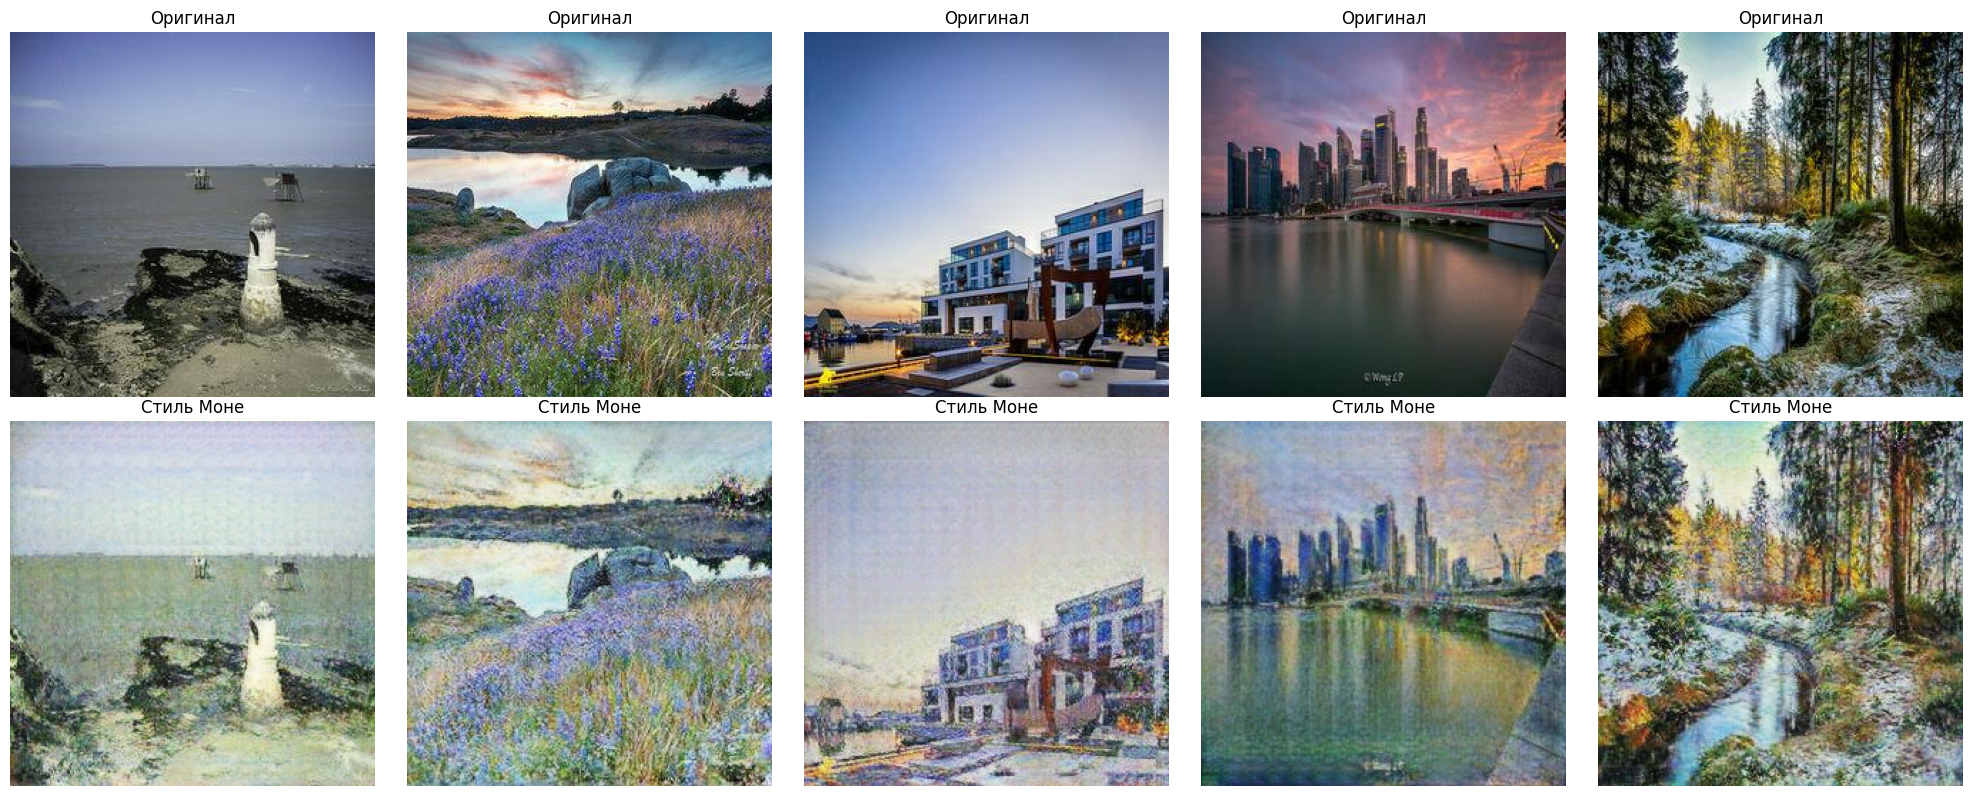

In [35]:
# Функция для быстрой визуализации результатов после обучения

def quick_generate_samples(model, photo_dir, num_samples=5):
    model.G_photo_to_monet.train()
    model.G_monet_to_photo.train()
    model.D_photo.train()
    model.D_monet.train()
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Выбор случайных фотографий для демонстрации
    photo_files = [f for f in os.listdir(photo_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    selected_photos = random.sample(photo_files, min(num_samples, len(photo_files)))
    
    print("Быстрая генерация примеров")
    
    # Визуализация примеров
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    if num_samples == 1:
        axes = axes.reshape(2, 1)
    
    with torch.no_grad():  
        for i, photo_file in tqdm(enumerate(selected_photos)):
            try:
                photo_path = os.path.join(photo_dir, photo_file)
                original_img = Image.open(photo_path).convert('RGB')
                
                # Преобравание в тензор и генерирование стилизованного изображения
                input_tensor = transform(original_img).unsqueeze(0).to(device)
                generated_monet = model.G_photo_to_monet(input_tensor)
                # Денормализация для отображения
                generated_monet = (generated_monet * 0.5 + 0.5).clamp(0, 1)
                generated_img = transforms.ToPILImage()(generated_monet.squeeze(0).cpu())
                
                # Отображение оригинала и результата
                axes[0, i].imshow(original_img)
                axes[0, i].set_title('Оригинал')
                axes[0, i].axis('off')
                
                axes[1, i].imshow(generated_img)
                axes[1, i].set_title('Стиль Моне')
                axes[1, i].axis('off')
                
                print(f"Обработано: {photo_file}")
                
            except Exception as e:
                print(f"Ошибка: {photo_file} - {e}")
                axes[0, i].axis('off')
                axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Визуализация результатов на num_samples случайных примерах
if os.path.exists(photo_dir):
    quick_generate_samples(model, photo_dir, num_samples=5)
else:
    print("Каталог с фото не найден!")

In [ ]:
# Генерация всех изображений для submission в Kaggle

generated_count, zip_name = generate_monet_images(
    model=model,
    photo_dir=photo_dir,
    zip_name='images.zip',  
    device=device,
    batch_size=8  
)

print(f"Сгенерировано {generated_count} изображений в файле {zip_name}")


In [ ]:
# Расширенная функция для визуализации - сравнение оригинального фото, генерации и реальной картины Моне

def visualize_results(model, photo_dir, monet_dir, num_samples=4):
    model.G_photo_to_monet.train()
    model.G_monet_to_photo.train()
    model.D_photo.train()
    model.D_monet.train()
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Выбор случайных изображений
    photo_files = [f for f in os.listdir(photo_dir) if f.endswith('.jpg')]
    monet_files = [f for f in os.listdir(monet_dir) if f.endswith('.jpg')]
    
    selected_photos = random.sample(photo_files, min(num_samples, len(photo_files)))
    selected_monets = random.sample(monet_files, min(num_samples, len(monet_files)))
    
    # Создание сетки
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))
    if num_samples == 1:
        axes = axes.reshape(3, 1)
    
    with torch.no_grad():
        for i in range(num_samples):
            # Загрузка и преобразование фотографии
            photo_path = os.path.join(photo_dir, selected_photos[i])
            photo_img = Image.open(photo_path).convert('RGB')
            photo_tensor = transform(photo_img).unsqueeze(0).to(model.device)
            
            # Генерирование изображения в стиле Моне
            fake_monet = model.G_photo_to_monet(photo_tensor)
            fake_monet = (fake_monet * 0.5 + 0.5).clamp(0, 1)  # Денормализация
            fake_monet_img = transforms.ToPILImage()(fake_monet.squeeze(0).cpu())
            
            # Загрузка реальной картины Моне для сравнения
            monet_path = os.path.join(monet_dir, selected_monets[i])
            monet_img = Image.open(monet_path).convert('RGB')
            
            # Отображение всех трех изображений в колонке
            axes[0, i].imshow(photo_img)
            axes[0, i].set_title('Оригинальная фотография')
            axes[0, i].axis('off')
            
            axes[1, i].imshow(fake_monet_img)
            axes[1, i].set_title('Сгенерированная картина')
            axes[1, i].axis('off')
            
            axes[2, i].imshow(monet_img)
            axes[2, i].set_title('Оригинальная картина Моне')
            axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
# Финальная визуализация для сравнения результатов модели с реальными картинами Моне

if os.path.exists(monet_dir) and os.path.exists(photo_dir):
    print('Примеры результатов.')
    visualize_results(model, photo_dir, monet_dir, num_samples=4)
else:
    print('Каталоги с данными не найдены. Проверьте пути к monet_dir и photo_dir.')



In [ ]:
task.close()